Fitting S21 data for resonator with `fit_resonator.FitResonator`

Let's starts with loading data.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from labcodes import fit_resonator
from pathlib import Path

dirc = Path('../data/resonator_s21')
df = pd.read_feather(next(dirc.glob('jj5*.feather')))
df

,freq,s21_dB,s21_rad
0,6.232750,-29.892473,-0.644771
1,6.232786,-29.905964,-0.657817
2,6.232823,-29.908421,-0.677758
3,6.232859,-29.924617,-0.695439
4,6.232896,-29.922979,-0.710094
...,...,...,...
1000,6.248604,-28.192774,-1.220563
1001,6.248640,-28.200958,-1.238153
1002,6.248677,-28.207445,-1.257188
1003,6.248714,-28.207672,-1.270492


Fitting is done by instancing `FitResonator`.

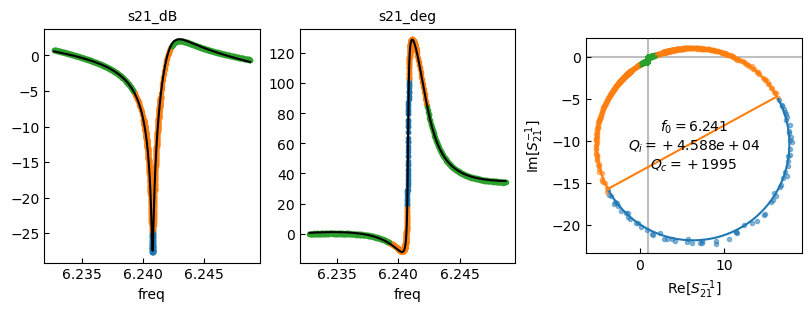

In [31]:
rfit = fit_resonator.FitResonator(df.freq, df.s21_dB, df.s21_rad)
rfit.plot()
rfit.result

# Custom fit: preparing data

Usually a fit contains following steps:

- Remove linear background (or electric delay).

- Guess initial parameters (Critical to success).

- Do fit (with given parameter constraints, data weigths)

- Plot fit result.

Quick view to fit result is available by `rfit.plot()`, `rfit.result`.

The first 3 steps are automatically done by calling `FitResonator(df.freq, df.s21_dB, df.s21_rad)`,
all done by default.

Sometimes fit fails with default configuration, one can easily custom these fitting steps.

The 1st step preparing data is done by `rfit.prepare_data` implictly, which can be skiped as below.

(<Axes: title={'center': 's21_dB'}, xlabel='freq'>,
 <Axes: title={'center': 's21_deg'}, xlabel='freq'>,
 <Axes: xlabel='Re[$S_{21}^{-1}$]', ylabel='Im[$S_{21}^{-1}$]'>)

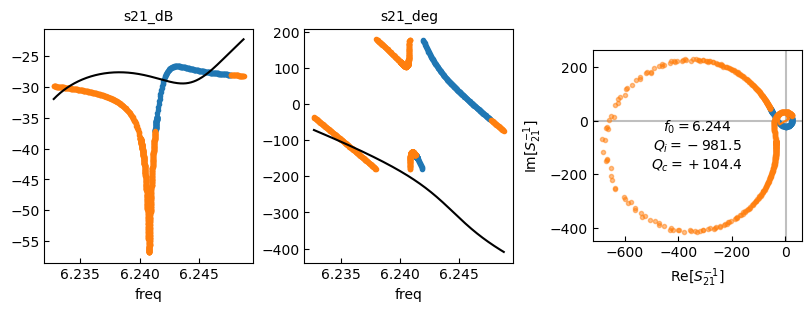

In [32]:
# Without data preparation, fit fails.
rfit = fit_resonator.FitResonator(df=df)
rfit.plot()

(<Axes: title={'center': 's21_dB'}, xlabel='freq'>,
 <Axes: title={'center': 's21_deg'}, xlabel='freq'>,
 <Axes: xlabel='Re[$S_{21}^{-1}$]', ylabel='Im[$S_{21}^{-1}$]'>)

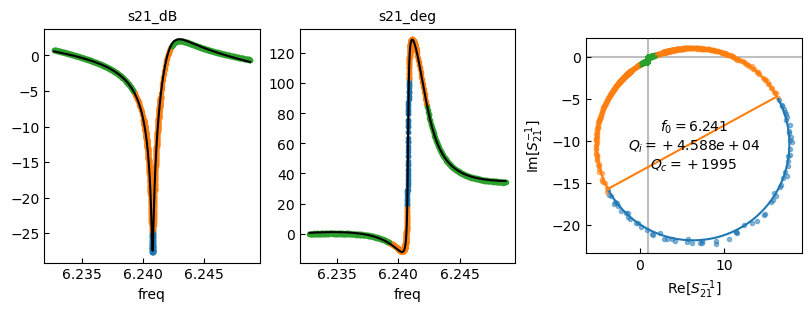

In [33]:
# Do some custom data preparation, here just call the build-in method.
df_custom = fit_resonator.FitResonator.prepare_data(
    df.freq, df.s21_dB, df.s21_rad)

# Now fit works.
rfit = fit_resonator.FitResonator(df=df_custom)
rfit.plot()

# Custom fit: initial values

Initial values and constraints are set by implictly calling `rfit.guess_params`,
and stored in `rfit.init_params`.
This attribute will be passed to fit when calling `rfit.fit()`

In [34]:
rfit.init_params

name,value,initial value,min,max,vary
Qi,49157.3472,49157.34715159975,-inf,inf,True
Qc,3559.65516,3559.655160834381,-inf,inf,True
f0,6.24079800,6.240798,-inf,inf,True
phi,0.00000000,0,-inf,inf,True
alpha,-62.9534114,-62.95341141261311,-inf,inf,True
phiv,-37.4615359,-37.46153592879694,-196.349541,196.349541,True
phi0,0.00000000,0,-inf,inf,True
amp,1.00000000,1,-inf,inf,True


In [35]:
rfit.init_params.set(Qc=dict(min=0, vary=True), phi0=-0.2)  # Modify it at will.
rfit.init_params

name,value,initial value,min,max,vary
Qi,49157.3472,49157.34715159975,-inf,inf,True
Qc,3559.65516,3559.655160834381,0.00000000,inf,True
f0,6.24079800,6.240798,-inf,inf,True
phi,0.00000000,0,-inf,inf,True
alpha,-62.9534114,-62.95341141261311,-inf,inf,True
phiv,-37.4615359,-37.46153592879694,-196.349541,196.349541,True
phi0,-0.20000000,-0.2,-inf,inf,True
amp,1.00000000,1,-inf,inf,True


In [36]:
rfit.fit()
rfit.result  # Modification takes effect.

Or provide initial values as keywork arguements to `rfit.fit`

In [37]:
rfit.fit(alpha=-170)
rfit.result

# Custom fit: weights and others

Beside parameter values, other fitting arguements can also passed to `rfit.fit`.

One important thing is `weights` of data.

Defaultly `FitResonator` uses `weights` that supresses contribution of data points around the dip.

But this strategy sometimes fails, here is an example.

54.484355992543115

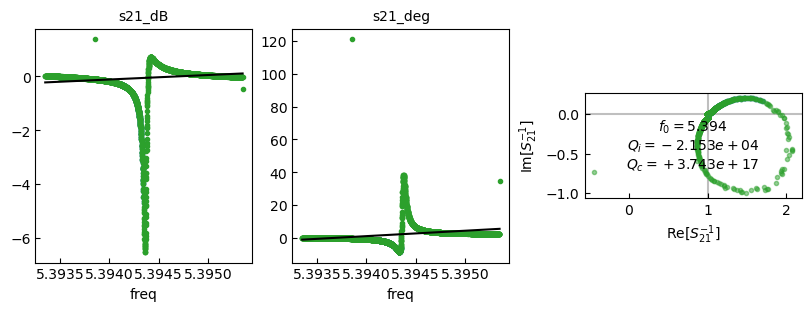

In [38]:
df = pd.read_feather(next(dirc.glob('lp11*.feather')))
rfit = fit_resonator.FitResonator(df.freq, df.s21_dB, df.s21_rad)
rfit.plot()
rfit.result.chisqr

2.6058500154322823

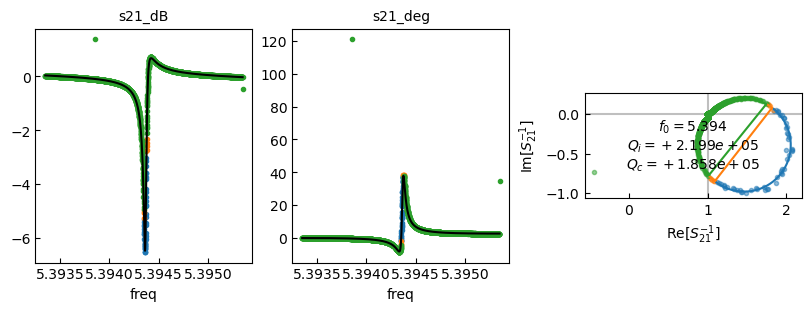

In [39]:
# Redo the fit with weights enhancing contribution of data points around the dip.
rfit.fit(weights=np.abs(1 / rfit.s21_cplx))
rfit.plot()
rfit.result.chisqr  # note the residue changes.

Other available configurations listed below.

In [40]:
fit_resonator.model.fit?

Signature:
fit_resonator.model.fit(
    data,
    params=None,
    weights=None,
    method='leastsq',
    iter_cb=None,
    scale_covar=True,
    verbose=False,
    fit_kws=None,
    nan_policy=None,
    calc_covar=True,
    max_nfev=None,
    coerce_farray=True,
    **kwargs,
)
Docstring:
Fit the model to the data using the supplied Parameters.

Parameters
----------
data : array_like
    Array of data to be fit.
params : Parameters, optional
    Parameters to use in fit (default is None).
weights : array_like, optional
    Weights to use for the calculation of the fit residual [i.e.,
    `weights*(data-fit)`]. Default is None; must have the same size as
    `data`.
method : str, optional
    Name of fitting method to use (default is `'leastsq'`).
iter_cb : callable, optional
    Callback function to call at each iteration (default is None).
scale_covar : bool, optional
    Whether to automatically scale the covariance matrix when
    calculating uncertainties (default is True).
verb

In [41]:
rfit.fit??

Signature: rfit.fit(**fit_kws) -> lmfit.minimizer.MinimizerResult
Docstring: fit(Qi=1e6) to overwrite initial guess.
Source:   
    def fit(self, **fit_kws) -> lmfit.minimizer.MinimizerResult:
        """fit(Qi=1e6) to overwrite initial guess.
        
        Defaultly uses `weights=np.abs(s21_cplx)`. Pass `weights=None` to disable any weights.
        """
        freq = self.df.freq.values
        s21_cplx = self.s21_cplx
        s21m1_cplx = 1 / s21_cplx

        if 'weights' not in fit_kws:
            # Lower weight around dip, for improved robustness with noisy data.
            # pass weights=None to disable any weights.
            fit_kws['weights'] = np.abs(s21_cplx)

        self.result = model.fit(
            s21m1_cplx,
            x=freq,
            params=self.init_params,
            method="Powell",
            **fit_kws,
        )
        return self.result
File:      d:\labcodes\labcodes\fit_resonator.py
Type:      method